In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scripts.datahandler import DataHandler
from scripts.modeler import Model
from scripts.priors import uniform
from scripts.sampler import luvfinder
from scripts.matchedfilter import *
from functools import partial

import os
import glob

# Data and model

In [2]:
# Create an instance of DataHandler.
msfile = './output/ms_files/line13_line9/line13_line9.alma.cycle10.3.noisy.ms'
Data = DataHandler(msfile)

2025-05-16 12:07:47	INFO	msmetadata_cmpt.cc::open	Performing internal consistency checks on ./output/ms_files/line13_line9/line13_line9.alma.cycle10.3.noisy.ms...


## Line 1

In [3]:
# Create your model and adjust parameters as needed.
dra =  12.0 # arcsec
ddec = -4.25 # arcsec
total_flux =  1.270e+00  # Jy km/s
bmin = 0.25 # arcsec
bmaj = 0.25 # arcsec
nu_center =  40.2e9 #Hz
linewidth = 300 # km/s

mod = Model()
gauss = Model.Gaussian(
    dra=dra,
    ddec=ddec,
    total_flux=total_flux,
    bmin=bmin,
    bmaj=bmaj,
    nu_center=nu_center,
    width=linewidth
)
mod.addcomponent(gauss)
Data.uvdata_model = gauss.profile(Data.uvdata)

In [4]:
#Model
Data.uvdata_model = Data.apply_phase_shift(dRA=dra, dDec=ddec, uvdata=Data.uvdata_model)

nvis = Data.n_visbs(Data.uvdata)
nfre = Data.n_freqs(Data.uvdata)

freqs = Data.uvdata.uvfreqs.reshape(nfre, nvis)[:, 0] / 1e9
mean_reals_model = np.average(Data.uvdata_model.UVreals.reshape(nfre, nvis), weights=Data.uvdata_model.uvwghts.reshape(nfre,nvis), axis=1)
mean_reals_model_shifted = np.average(Data.uvdata_model.UVreals_shifted.reshape(nfre,nvis), weights=Data.uvdata_model.uvwghts.reshape(nfre,nvis), axis=1)

mean_imags_model = np.average(Data.uvdata_model.UVimags.reshape(nfre, nvis), weights=Data.uvdata_model.uvwghts.reshape(nfre,nvis), axis=1)
mean_imags_model_shifted = np.average(Data.uvdata_model.UVimags_shifted.reshape(nfre, nvis), weights=Data.uvdata_model.uvwghts.reshape(nfre,nvis), axis=1)

# Data 
Data.uvdata = Data.apply_phase_shift(dRA=dra, dDec=ddec, uvdata=Data.uvdata)

mean_reals = np.average(Data.uvdata.UVreals.reshape(nfre, nvis), weights = Data.uvdata.uvwghts.reshape(nfre,nvis),axis=1)
mean_reals_shifted = np.average(Data.uvdata.UVreals_shifted.reshape(nfre,nvis), weights = Data.uvdata.uvwghts.reshape(nfre,nvis),axis=1)

mean_imags = np.average(Data.uvdata.UVimags.reshape(nfre, nvis), weights = Data.uvdata.uvwghts.reshape(nfre,nvis),axis=1)
mean_imags_shifted = np.average(Data.uvdata.UVimags_shifted.reshape(nfre, nvis), weights = Data.uvdata.uvwghts.reshape(nfre,nvis),axis=1)

# jackknife both
Data.uvdata_split = Data.jackknife(Data.uvdata)
Data.uvdata_split = Data.apply_phase_shift(dRA=dra, dDec=ddec, uvdata=Data.uvdata_split)

Data.uvdata_model_split = Data.jackknife(Data.uvdata_model)
Data.uvdata_model_split = Data.apply_phase_shift(dRA=dra, dDec=ddec, uvdata=Data.uvdata_model)

nvis_split = Data.n_visbs(Data.uvdata_split)

mean_reals_split = np.average(Data.uvdata_split.UVreals.reshape(nfre, nvis_split), weights = Data.uvdata_split.uvwghts.reshape(nfre,nvis_split),axis=1)
mean_reals_split_shifted = np.average(Data.uvdata_split.UVreals_shifted.reshape(nfre,nvis_split), weights = Data.uvdata_split.uvwghts.reshape(nfre,nvis_split),axis=1)
mean_imags_split = np.average(Data.uvdata_split.UVimags.reshape(nfre, nvis_split), weights = Data.uvdata_split.uvwghts.reshape(nfre,nvis_split),axis=1)
mean_imags_split_shifted = np.average(Data.uvdata_split.UVimags_shifted.reshape(nfre, nvis_split), weights = Data.uvdata_split.uvwghts.reshape(nfre,nvis_split),axis=1)

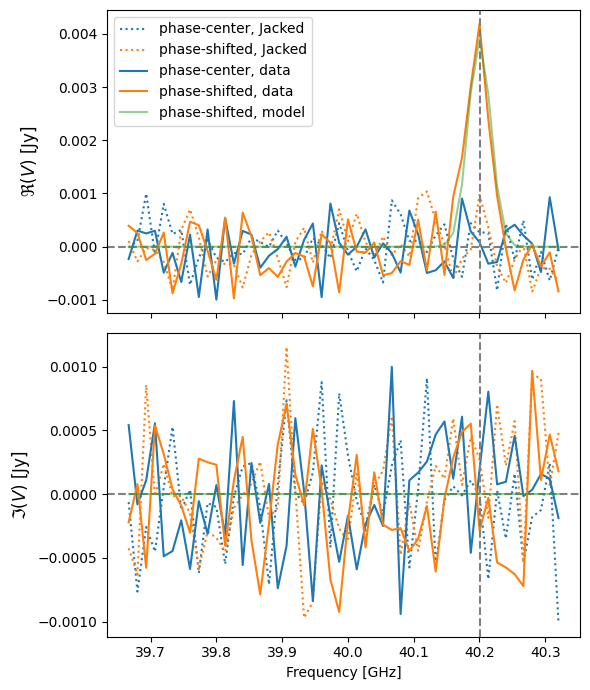

In [5]:

# Plot the model visibilities.
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 7))

ax1.axhline(0, c='gray', ls = '--')
ax2.axhline(0, c='gray', ls = '--')

ax1.plot(freqs, mean_reals_split, label='phase-center, Jacked', c='C0',ls=':')
ax1.plot(freqs, mean_reals_split_shifted, label='phase-shifted, Jacked', c='C1',ls=':')
ax1.plot(freqs, mean_reals, label='phase-center, data', c='C0', ls='-')
ax1.plot(freqs, mean_reals_shifted, label='phase-shifted, data', c='C1', ls='-')
# ax1.plot(freqs, mean_reals_model, label='phase-center, model', c='C0', ls='-', alpha=0.5)
ax1.plot(freqs, mean_reals_model_shifted, label='phase-shifted, model', c='C2', ls='-', alpha=0.5)
ax1.axvline(freqs[np.argmax(mean_reals_model_shifted)], c='gray', ls = '--')

# The example you already have in your code
ax1.set_ylabel(r'$\Re(V)$ [Jy]', fontsize=12)  # Real part of the visibility
ax1.legend()

ax2.plot(freqs, mean_imags_split, label='phase-center, Jacked', c='C0',ls=':')
ax2.plot(freqs, mean_imags_split_shifted, label='phase-shifted, Jacked', c='C1',ls=':')
ax2.plot(freqs, mean_imags, label='phase-center, data', c='C0', ls='-')
ax2.plot(freqs, mean_imags_shifted, label='phase-shifted, data', c='C1', ls='-')
# ax2.plot(freqs, mean_imags_model, label='phase-center, model', c='C0', ls='-', alpha=0.5)
ax2.plot(freqs, mean_imags_model_shifted, label='phase-shifted, model', c='C2', ls='-', alpha=0.5)
ax2.axvline(freqs[np.argmax(mean_reals_model_shifted)], c='gray', ls = '--')

ax2.set_xlabel('Frequency [GHz]')
ax2.set_ylabel(r'$\Im(V)$ [Jy]', fontsize=12)  # Real part of the visibility
plt.tight_layout()
plt.savefig('./plots/data_model.png')
plt.show()

SNR (integrated over 2xFWHM, std-based): 11.07
SNR (integrated over 2xFWHM, weighted error): 11.36
SNR (integrated over 2xFWHM, weighted error corrected): 11.36
SNR (peak in region): 9.35
Region: [40.1599, 40.2403] GHz, N_chan=7, noise_std=0.0004482


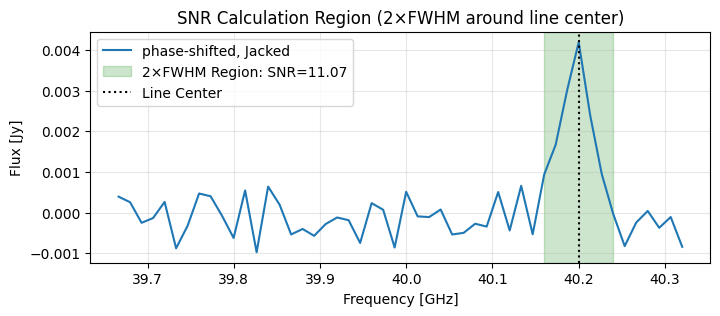

In [6]:
# --- SNR calculation for mean_reals_shifted ---
# Estimate SNR in the same way as in Test cell 5, but for mean_reals_shifted

# Assume the line is centered at the frequency of the model pe
signal_center = freqs[np.argmax(mean_reals_model_shifted)]
# Estimate FWHM in GHz (convert linewidth in km/s to GHz)
fwhm_ghz = (linewidth / 3e5) * nu_center / 1e9 
region_min = signal_center - fwhm_ghz
region_max = signal_center + fwhm_ghz

region_indices = np.where((freqs >= region_min) & (freqs <= region_max))[0]
df = freqs[1] - freqs[0] 

measured_flux = np.sum(mean_reals_shifted[region_indices]) * df
# Estimate noise per channel as the std of the off-line region (outside 2xFWHM)
off_indices = np.where((freqs < region_min) | (freqs > region_max))[0]
noise_std = np.std(mean_reals_shifted[off_indices]) 
noise_flux = len(region_indices)**0.5 * noise_std * df

snr_flux = measured_flux / noise_flux
snr_peak = np.max(mean_reals_shifted[region_indices]) / noise_std

weights_2d = Data.uvdata.uvwghts.reshape(nfre, nvis)
region_weights = weights_2d[region_indices, :]
chan_var = 1.0 / np.sum(region_weights, axis=1)
sum_err = np.sqrt(np.sum(chan_var)) * df
snr_weighted = measured_flux / sum_err
print(f"SNR (integrated over 2xFWHM, std-based): {snr_flux:.2f}")
print(f"SNR (integrated over 2xFWHM, weighted error): {snr_weighted:.2f}")
print(f"SNR (integrated over 2xFWHM, weighted error corrected): {snr_weighted:.2f}")
print(f"SNR (peak in region): {snr_peak:.2f}")
print(f"Region: [{region_min:.4f}, {region_max:.4f}] GHz, N_chan={len(region_indices)}, noise_std={noise_std:.4g}")

plt.figure(figsize=(8, 3))
plt.plot(freqs, mean_reals_shifted, label='phase-shifted, Jacked')
plt.axvspan(region_min, region_max, alpha=0.2, color='green', label=f'2×FWHM Region: SNR={snr_flux:.2f}')
plt.axvline(signal_center, color='k', linestyle=':', label='Line Center')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Flux [Jy]')
plt.title('SNR Calculation Region (2×FWHM around line center)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

2025-05-16 12:07:49	INFO	msmetadata_cmpt.cc::open	Performing internal consistency checks on ./output/ms_files/line13_line9/line13_line9.alma.cycle10.3.noisy.ms...
Grid Search Progress: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it]


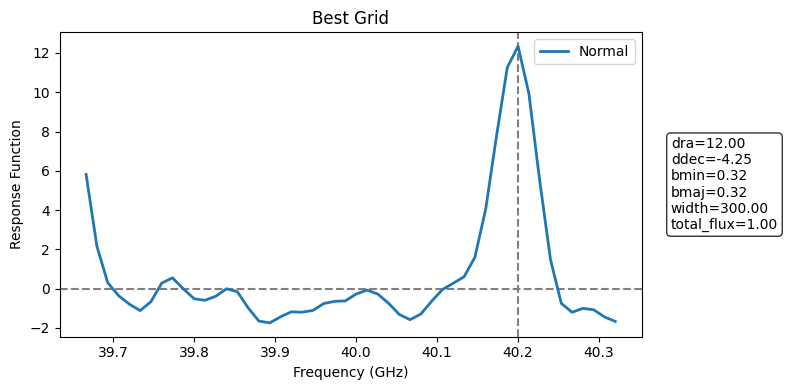

In [7]:
#dra --> there is a minus difference in how I define dra here and in the modeler

# Create an instance of DataHandler.
# msfile = './output/ms_files/line13_line9/line13_line9.alma.cycle10.3.noisy.ms'
# Data = DataHandler(msfile)

fov = Data.metadata.primarybeamsize()
res = Data.metadata.minresolution()

mod = Model()
gaussian = Model.Gaussian()
gaussian.grid = { # make it search the entire data set automatically
    # 'dra': np.arange(-fov/2*0.8, fov/2*0.8, res/2),
    # 'ddec': np.arange(-fov/2*0.8, fov/2*0.8, res/2),
    'dra': np.array([dra]),
    'ddec': np.array([ddec]),
    'bmin': np.array([res/10]),
    'bmaj': np.array([res/10]),
    'width': np.array([300]), # there is a weird shift of the response as function of this
    'total_flux': np.array([1.]),
    'nu_center':  partial(nu_center_func, uvfreq_min=Data.uvdata.uvfreqs.min())  # there is a weird shift of the response as function of this
    }

# Create a Model instance and add the Gaussian component.
mod.addcomponent(gaussian)

Filter = matchluvfinder(Data, mod)
Filter.run(pool=1, jackknife=False)
Filter.plot_response(show=True, vline=freqs[np.argmax(mean_reals_model_shifted)])

## Line 2

In [8]:
# Create your model and adjust parameters as needed.
dra =  4.25 # arcsec
ddec = 23.5 # arcsec
total_flux =  1.600e+00  # Jy km/s
bmin = 0.25 # arcsec
bmaj = 0.25 # arcsec
nu_center =  39.9e9 #Hz
linewidth = 300 # km/s

mod = Model()
gauss = Model.Gaussian(
    dra=dra,
    ddec=ddec,
    total_flux=total_flux,
    bmin=bmin,
    bmaj=bmaj,
    nu_center=nu_center,
    width=linewidth
)
mod.addcomponent(gauss)
Data.uvdata_model = gauss.profile(Data.uvdata)

In [9]:
#Model
Data.uvdata_model = Data.apply_phase_shift(dRA=dra, dDec=ddec, uvdata=Data.uvdata_model)

nvis = Data.n_visbs(Data.uvdata)
nfre = Data.n_freqs(Data.uvdata)

freqs = Data.uvdata.uvfreqs.reshape(nfre, nvis)[:, 0] / 1e9
mean_reals_model = np.average(Data.uvdata_model.UVreals.reshape(nfre, nvis), weights=Data.uvdata_model.uvwghts.reshape(nfre,nvis), axis=1)
mean_reals_model_shifted = np.average(Data.uvdata_model.UVreals_shifted.reshape(nfre,nvis), weights=Data.uvdata_model.uvwghts.reshape(nfre,nvis), axis=1)

mean_imags_model = np.average(Data.uvdata_model.UVimags.reshape(nfre, nvis), weights=Data.uvdata_model.uvwghts.reshape(nfre,nvis), axis=1)
mean_imags_model_shifted = np.average(Data.uvdata_model.UVimags_shifted.reshape(nfre, nvis), weights=Data.uvdata_model.uvwghts.reshape(nfre,nvis), axis=1)

# Data 
Data.uvdata = Data.apply_phase_shift(dRA=dra, dDec=ddec, uvdata=Data.uvdata)

mean_reals = np.average(Data.uvdata.UVreals.reshape(nfre, nvis), weights = Data.uvdata.uvwghts.reshape(nfre,nvis),axis=1)
mean_reals_shifted = np.average(Data.uvdata.UVreals_shifted.reshape(nfre,nvis), weights = Data.uvdata.uvwghts.reshape(nfre,nvis),axis=1)

mean_imags = np.average(Data.uvdata.UVimags.reshape(nfre, nvis), weights = Data.uvdata.uvwghts.reshape(nfre,nvis),axis=1)
mean_imags_shifted = np.average(Data.uvdata.UVimags_shifted.reshape(nfre, nvis), weights = Data.uvdata.uvwghts.reshape(nfre,nvis),axis=1)

# jackknife both
Data.uvdata_split = Data.jackknife(Data.uvdata)
Data.uvdata_split = Data.apply_phase_shift(dRA=dra, dDec=ddec, uvdata=Data.uvdata_split)

Data.uvdata_model_split = Data.jackknife(Data.uvdata_model)
Data.uvdata_model_split = Data.apply_phase_shift(dRA=dra, dDec=ddec, uvdata=Data.uvdata_model)

nvis_split = Data.n_visbs(Data.uvdata_split)

mean_reals_split = np.average(Data.uvdata_split.UVreals.reshape(nfre, nvis_split), weights = Data.uvdata_split.uvwghts.reshape(nfre,nvis_split),axis=1)
mean_reals_split_shifted = np.average(Data.uvdata_split.UVreals_shifted.reshape(nfre,nvis_split), weights = Data.uvdata_split.uvwghts.reshape(nfre,nvis_split),axis=1)
mean_imags_split = np.average(Data.uvdata_split.UVimags.reshape(nfre, nvis_split), weights = Data.uvdata_split.uvwghts.reshape(nfre,nvis_split),axis=1)
mean_imags_split_shifted = np.average(Data.uvdata_split.UVimags_shifted.reshape(nfre, nvis_split), weights = Data.uvdata_split.uvwghts.reshape(nfre,nvis_split),axis=1)

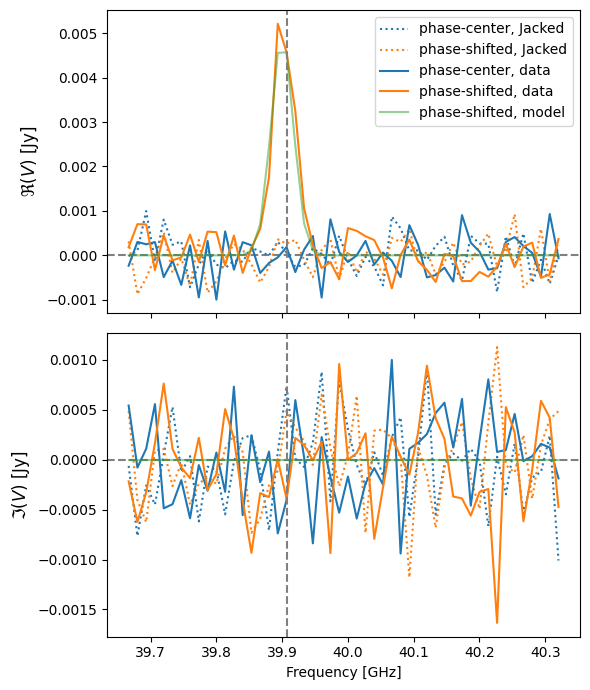

In [10]:

# Plot the model visibilities.
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 7))

ax1.axhline(0, c='gray', ls = '--')
ax2.axhline(0, c='gray', ls = '--')

ax1.plot(freqs, mean_reals_split, label='phase-center, Jacked', c='C0',ls=':')
ax1.plot(freqs, mean_reals_split_shifted, label='phase-shifted, Jacked', c='C1',ls=':')
ax1.plot(freqs, mean_reals, label='phase-center, data', c='C0', ls='-')
ax1.plot(freqs, mean_reals_shifted, label='phase-shifted, data', c='C1', ls='-')
# ax1.plot(freqs, mean_reals_model, label='phase-center, model', c='C0', ls='-', alpha=0.5)
ax1.plot(freqs, mean_reals_model_shifted, label='phase-shifted, model', c='C2', ls='-', alpha=0.5)
ax1.axvline(freqs[np.argmax(mean_reals_model_shifted)], c='gray', ls = '--')

# The example you already have in your code
ax1.set_ylabel(r'$\Re(V)$ [Jy]', fontsize=12)  # Real part of the visibility
ax1.legend()

ax2.plot(freqs, mean_imags_split, label='phase-center, Jacked', c='C0',ls=':')
ax2.plot(freqs, mean_imags_split_shifted, label='phase-shifted, Jacked', c='C1',ls=':')
ax2.plot(freqs, mean_imags, label='phase-center, data', c='C0', ls='-')
ax2.plot(freqs, mean_imags_shifted, label='phase-shifted, data', c='C1', ls='-')
# ax2.plot(freqs, mean_imags_model, label='phase-center, model', c='C0', ls='-', alpha=0.5)
ax2.plot(freqs, mean_imags_model_shifted, label='phase-shifted, model', c='C2', ls='-', alpha=0.5)
ax2.axvline(freqs[np.argmax(mean_reals_model_shifted)], c='gray', ls = '--')

ax2.set_xlabel('Frequency [GHz]')
ax2.set_ylabel(r'$\Im(V)$ [Jy]', fontsize=12)  # Real part of the visibility
plt.tight_layout()
plt.savefig('./plots/data_model.png')
plt.show()

SNR (integrated over 2xFWHM, std-based): 17.42
SNR (integrated over 2xFWHM, weighted error): 16.21
SNR (integrated over 2xFWHM, weighted error corrected): 16.21
SNR (peak in region): 12.82
Region: [39.8667, 39.9465] GHz, N_chan=5, noise_std=0.0004064


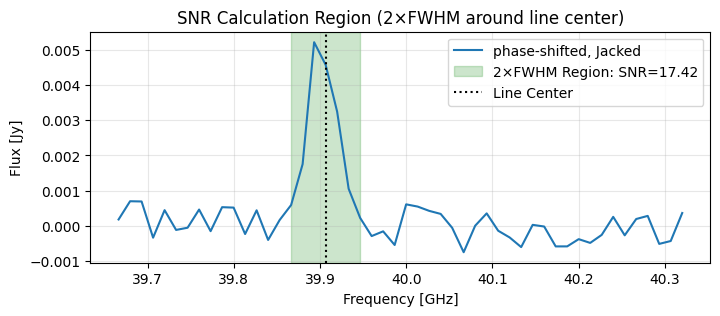

In [11]:
# --- SNR calculation for mean_reals_shifted ---
# Estimate SNR in the same way as in Test cell 5, but for mean_reals_shifted

# Assume the line is centered at the frequency of the model pe
signal_center = freqs[np.argmax(mean_reals_model_shifted)]
# Estimate FWHM in GHz (convert linewidth in km/s to GHz)
fwhm_ghz = (linewidth / 3e5) * nu_center / 1e9 
region_min = signal_center - fwhm_ghz
region_max = signal_center + fwhm_ghz

region_indices = np.where((freqs >= region_min) & (freqs <= region_max))[0]
df = freqs[1] - freqs[0] 

measured_flux = np.sum(mean_reals_shifted[region_indices]) * df
# Estimate noise per channel as the std of the off-line region (outside 2xFWHM)
off_indices = np.where((freqs < region_min) | (freqs > region_max))[0]
noise_std = np.std(mean_reals_shifted[off_indices]) 
noise_flux = len(region_indices)**0.5 * noise_std * df

snr_flux = measured_flux / noise_flux
snr_peak = np.max(mean_reals_shifted[region_indices]) / noise_std

weights_2d = Data.uvdata.uvwghts.reshape(nfre, nvis)
region_weights = weights_2d[region_indices, :]
chan_var = 1.0 / np.sum(region_weights, axis=1)
sum_err = np.sqrt(np.sum(chan_var)) * df
snr_weighted = measured_flux / sum_err
print(f"SNR (integrated over 2xFWHM, std-based): {snr_flux:.2f}")
print(f"SNR (integrated over 2xFWHM, weighted error): {snr_weighted:.2f}")
print(f"SNR (integrated over 2xFWHM, weighted error corrected): {snr_weighted:.2f}")
print(f"SNR (peak in region): {snr_peak:.2f}")
print(f"Region: [{region_min:.4f}, {region_max:.4f}] GHz, N_chan={len(region_indices)}, noise_std={noise_std:.4g}")

plt.figure(figsize=(8, 3))
plt.plot(freqs, mean_reals_shifted, label='phase-shifted, Jacked')
plt.axvspan(region_min, region_max, alpha=0.2, color='green', label=f'2×FWHM Region: SNR={snr_flux:.2f}')
plt.axvline(signal_center, color='k', linestyle=':', label='Line Center')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Flux [Jy]')
plt.title('SNR Calculation Region (2×FWHM around line center)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Grid Search Progress: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it]


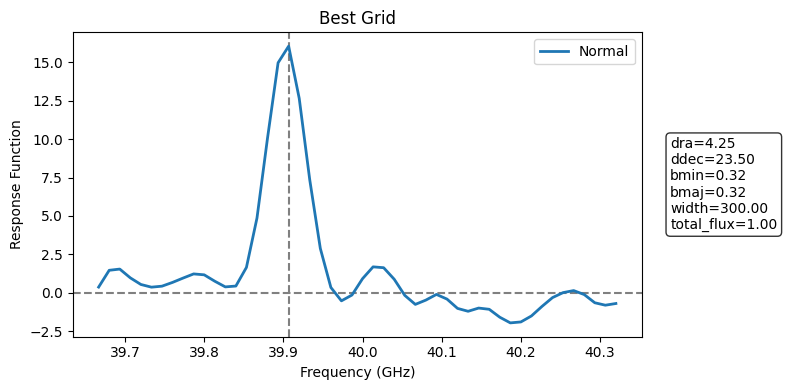

In [12]:
# Create an instance of DataHandler.

mod = Model()
gaussian = Model.Gaussian()
gaussian.grid = { # make it search the entire data set automatically
    # 'dra': np.arange(-fov/2*0.8, fov/2*0.8, res/2),
    # 'ddec': np.arange(-fov/2*0.8, fov/2*0.8, res/2),
    'dra': np.array([4.25]),
    'ddec': np.array([23.5]),
    'bmin': np.array([res/10]),
    'bmaj': np.array([res/10]),
    'width': np.array([300]), # there is a weird shift of the response as function of this
    'total_flux': np.array([1.]),
    'nu_center':  partial(nu_center_func, uvfreq_min=Data.uvdata.uvfreqs.min())  # there is a weird shift of the response as function of this
    }

# Create a Model instance and add the Gaussian component.
mod.addcomponent(gaussian)

Filter = matchluvfinder(Data, mod)
Filter.run(pool=1, jackknife=False)
Filter.plot_response(show=True, vline=freqs[np.argmax(mean_reals_model_shifted)])

In [13]:
logs = glob.glob('./casa*.log'); [os.remove(f) for f in logs]; print(f"Removed {len(logs)} casa log files")


Removed 3 casa log files


# Sampler tester

In [14]:
# %load_ext autoreload
# %autoreload 2

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import integrate
# from scripts.datahandler import DataHandler
# from scripts.modeler import Model
# from scripts.priors import uniform
# from scripts.sampler import luvfinder
# from scripts.matchedfilter import *
# from functools import partial


In [15]:
# # Create an instance of DataHandler.
# msfile = './output/ms_files/line10_line10/line10_line10.alma.cycle10.3.noisy.ms'
# Data = DataHandler(msfile)

# # Define flat (uniform) priors using your helper functions.
# # Create your model and adjust parameters as needed.
# fov = Data.metadata.primarybeamsize()
# res = Data.metadata.minresolution()

# mod = Model()
# gaussian = Model.Gaussian() 
# gaussian.priors = { # make it search the entire data set automatically
#     # 'dra': uniform(-fov/2*0.8, fov/2*0.8),
#     # 'ddec': uniform(-fov/2*0.8, +fov/2*0.8),
#     'dra': uniform(dra-1,dra+1),
#     'ddec': uniform(ddec-1,ddec+1),
#     'total_flux': uniform(1., 2),
#     'bmin': uniform(res/10, res),
#     'bmaj': uniform(res/10, res),
#     'nu_center': uniform(Data.uvdata.uvfreqs.min(),Data.uvdata.uvfreqs.max()),
#     'width': uniform(100, 500)
# }

# # Create a Model instance and add the Gaussian component.
# mod.addcomponent(gaussian)


In [16]:
# Sampler = luvfinder(Data.uvdata, mod)
# Sampler.run(pool=10, dlogz=0.01, n_live=1000)
# Sampler.plot_corner(show=True)


# Data.uvdata_sampler= Sampler.getmodel()
# Data.uvdata_sampler = Data.apply_phase_shift(dRA=12.0, dDec=-4.25, uvdata=Data.uvdata_sampler)
# mean_reals_sampler = np.mean(Data.uvdata_sampler.UVreals.reshape(nfre, nvis), axis=1)
# mean_reals_sampler_shifted = np.mean(Data.uvdata_sampler.UVreals_shifted.reshape(nfre,nvis), axis=1)

# # Plot the model visibilities.
# plt.figure()
# plt.plot(freqs, mean_reals_sampler, label='phase-center, sampler', c='C0', ls='-', alpha=0.5)
# plt.plot(freqs, mean_reals_sampler_shifted, label='phase-shifted, sampler', c='C1', ls='-', alpha=0.5)

# plt.plot(freqs, mean_reals, label='phase-center, data', c='C0', ls='-')
# plt.plot(freqs, mean_reals_shifted, label='phase-shifted, data', c='C1', ls='-')

# plt.xlabel('Frequency [GHz]')
# plt.ylabel('Flux [Jy]')
# plt.legend()
# plt.show()

In [17]:
# # Create an instance of DataHandler.
# msfile = './output/ms_files/line5_line10/line5_line10.alma.cycle10.3.noisy.ms'
# Data = DataHandler(msfile)

# # Define flat (uniform) priors using your helper functions.
# # Create your model and adjust parameters as needed.
# fov = Data.metadata.primarybeamsize()
# res = Data.metadata.minresolution()

# mod = Model()
# gaussian = Model.Gaussian() 
# gaussian.priors = { # make it search the entire data set automatically
#     'dra': uniform(-fov/2*0.8, fov/2*0.8),
#     'ddec': uniform(-fov/2*0.8, +fov/2*0.8),
#     # 'dra': uniform(dra-1,dra+1),
#     # 'ddec': uniform(ddec-1,ddec+1),
#     'total_flux': uniform(0., 10),
#     'bmin': uniform(res/10, res),
#     'bmaj': uniform(res/10, res),
#     'nu_center': uniform(Data.uvdata.uvfreqs.min(),Data.uvdata.uvfreqs.max()),
#     'width': uniform(50, 600)
# }

# # Create a Model instance and add the Gaussian component.
# mod.addcomponent(gaussian)


In [18]:
# Sampler = luvfinder(Data.uvdata, mod)
# Sampler.run(pool=10, dlogz=0.01, n_live=1000)
# Sampler.plot_corner(show=True)


# Data.uvdata_sampler= Sampler.getmodel()
# Data.uvdata_sampler = Data.apply_phase_shift(dRA=12.0, dDec=-4.25, uvdata=Data.uvdata_sampler)
# mean_reals_sampler = np.mean(Data.uvdata_sampler.UVreals.reshape(nfre, nvis), axis=1)
# mean_reals_sampler_shifted = np.mean(Data.uvdata_sampler.UVreals_shifted.reshape(nfre,nvis), axis=1)

# # Plot the model visibilities.
# plt.figure()
# plt.plot(freqs, mean_reals_sampler, label='phase-center, sampler', c='C0', ls='-', alpha=0.5)
# plt.plot(freqs, mean_reals_sampler_shifted, label='phase-shifted, sampler', c='C1', ls='-', alpha=0.5)

# plt.plot(freqs, mean_reals, label='phase-center, data', c='C0', ls='-')
# plt.plot(freqs, mean_reals_shifted, label='phase-shifted, data', c='C1', ls='-')

# plt.xlabel('Frequency [GHz]')
# plt.ylabel('Flux [Jy]')
# plt.legend()
# plt.show()